In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('GLD.csv', parse_dates = True, index_col = 0)

FileNotFoundError: ignored

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-11-18,44.430000,44.490002,44.070000,44.380001,44.380001,5992000
2004-11-19,44.490002,44.919998,44.470001,44.779999,44.779999,11655300
2004-11-22,44.750000,44.970001,44.740002,44.950001,44.950001,11996000
2004-11-23,44.880001,44.919998,44.720001,44.750000,44.750000,3169200
2004-11-24,44.930000,45.049999,44.790001,45.049999,45.049999,6105100


In [ ]:
df_settle = df['Adj Close'].resample('M').last()

In [ ]:
df_settle

Date
2004-11-30     45.119999
2004-12-31     43.799999
2005-01-31     42.220001
2005-02-28     43.529999
2005-03-31     42.820000
                 ...    
2021-07-31    169.820007
2021-08-31    169.690002
2021-09-30    164.220001
2021-10-31    166.649994
2021-11-30    166.619995
Freq: M, Name: Adj Close, Length: 205, dtype: float64

In [ ]:
df_rolling = df_settle.rolling(12)
df_mean = df_rolling.mean()
df_std = df_rolling.std()

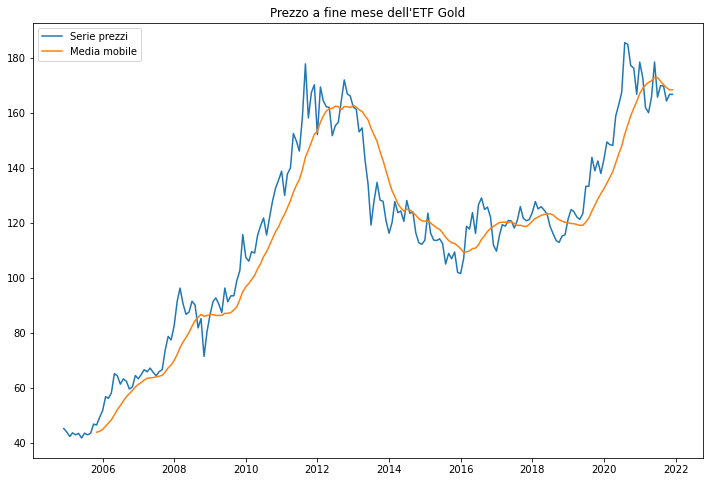

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(df_settle, label = 'Serie prezzi')
plt.plot(df_mean, label = 'Media mobile')
plt.legend()
plt.title("Prezzo a fine mese dell'ETF Gold")
plt.show()

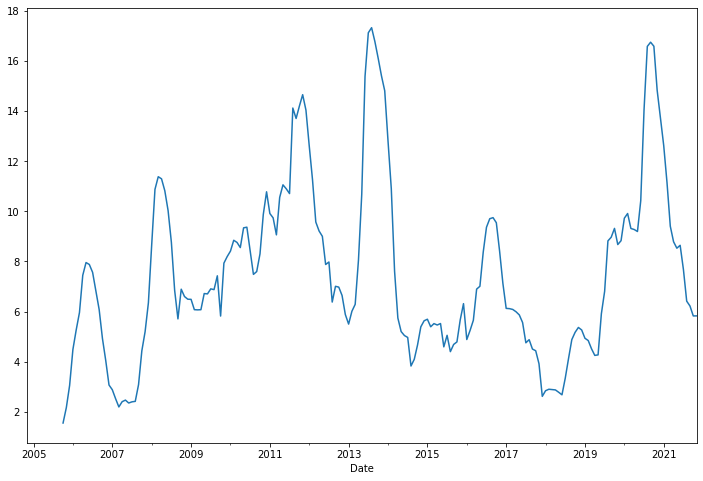

In [ ]:
df_std.plot(figsize=(12,8));

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
result = adfuller(df_settle)

In [ ]:
print('ADF statistic: ', result[0])
print('p-value: ', result[1])

critical_values = result[4]

for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))

ADF statistic:  -1.529338702549297
p-value:  0.5189512211117554
Critical value (1%): -3.463
Critical value (5%): -2.876
Critical value (10%): -2.574


Detrending

In [ ]:
df_log = np.log(df_settle)

In [ ]:
df_log_ma = df_log.rolling(2).mean()

In [ ]:
df_detrend = df_log - df_log_ma
df_detrend.dropna(inplace= True)

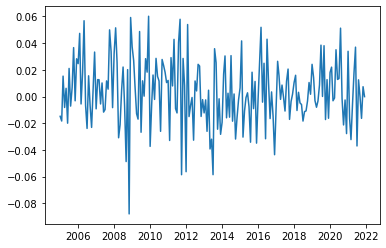

In [ ]:
plt.plot(df_detrend)

In [ ]:
df_detrend_rolling = df_detrend.rolling(12)
df_detrend_ma = df_detrend_rolling.mean()
df_detrend_std = df_detrend_rolling.std()

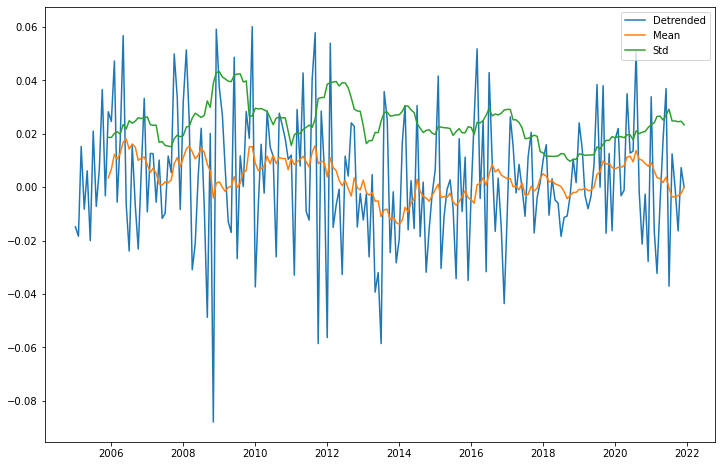

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(df_detrend, label = 'Detrended')
plt.plot(df_detrend_ma, label = 'Mean')
plt.plot(df_detrend_std, label = 'Std')
plt.legend(loc='upper right');

In [ ]:
result = adfuller(df_detrend)
print('ADF statistic: ', result[0])
print('p-value: ', round(result[1],5))

critical_values = result[4]

for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))


ADF statistic:  -15.807642925906947
p-value:  0.0
Critical value (1%): -3.463
Critical value (5%): -2.876
Critical value (10%): -2.574


In [ ]:
df_log_diff = df_log.diff(3).dropna()

df_log_diff_rolling = df_log_diff.rolling(12)
df_diff_ma = df_log_diff_rolling.mean()
df_diff_std = df_log_diff_rolling.std()


(-0.1, 0.15)

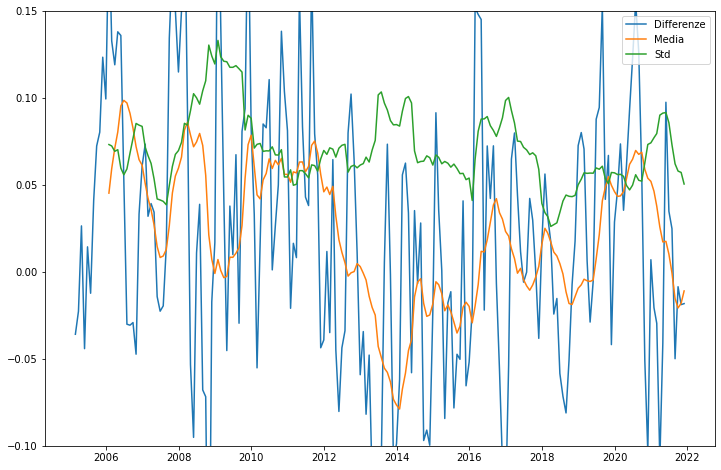

In [ ]:
plt.figure(figsize = (12,8))
plt.plot(df_log_diff, label = 'Differenze')
plt.plot(df_diff_ma, label = 'Media')
plt.plot(df_diff_std, label = 'Std')
plt.legend(loc = 'upper right')
plt.ylim((-0.10, 0.15))

In [ ]:
result = adfuller(df_log_diff)
print('ADF statistic: ', result[0])
print('p-value: ', round(result[1], 5))

critical_values = result[4]

for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))



ADF statistic:  -2.9994108772984625
p-value:  0.03495
Critical value (1%): -3.465
Critical value (5%): -2.877
Critical value (10%): -2.575


#### Scomposizione 

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
decompose_result = seasonal_decompose(df_log.dropna()) #freq=12)

In [ ]:
df_trend = decompose_result.trend
df_season = decompose_result.seasonal
df_residual = decompose_result.resid

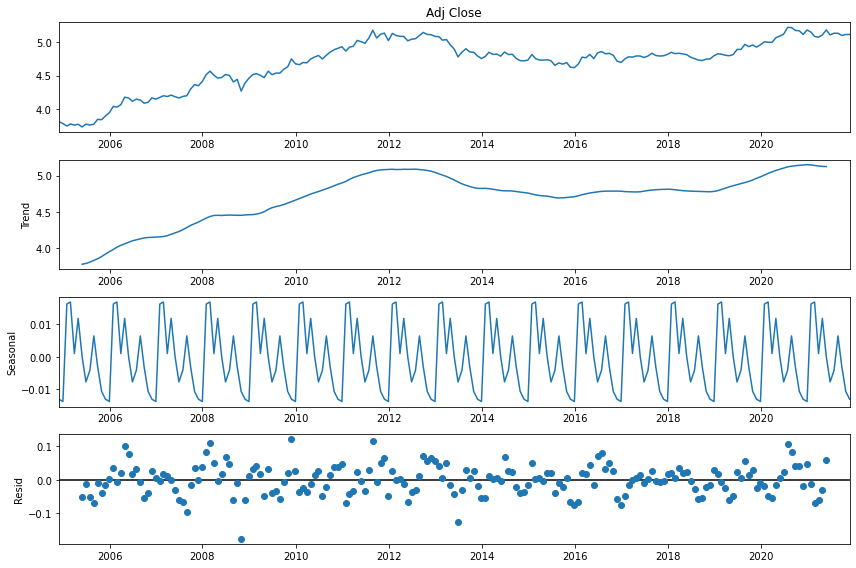

In [ ]:
plt.rcParams['figure.figsize'] = (12,8)
fig = decompose_result.plot()

In [ ]:
df_log_diff = df_residual.diff().dropna()

In [ ]:
df_diff_rolling = df_log_diff.rolling(12)
df_diff_ma = df_diff_rolling.mean()
df_diff_std = df_diff_rolling.std()

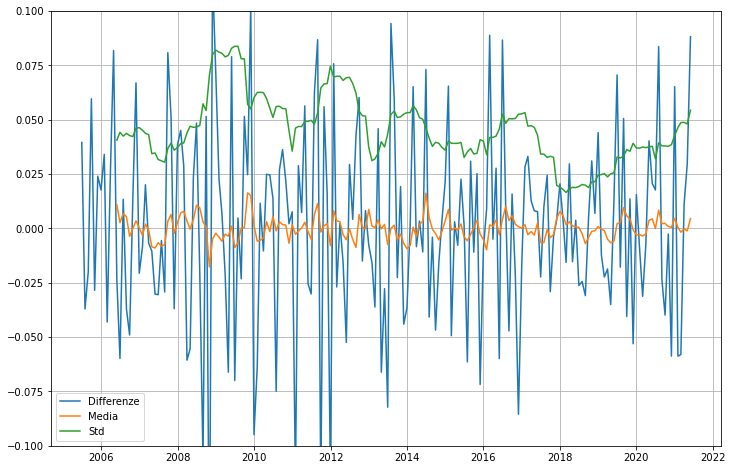

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(df_log_diff, label = 'Differenze')
plt.plot(df_diff_ma, label = 'Media')
plt.plot(df_diff_std, label = 'Std')
plt.grid(True)
plt.ylim((-0.10, 0.10))
plt.legend();

In [ ]:
result = adfuller(df_residual.dropna())
print('ADF statistic: ', result[0])
print('p-value: ', round(result[1], 5))

critical_values = result[4]

for key, value in critical_values.items():
    print('Critical value (%s): %.3f' % (key, value))


ADF statistic:  -5.835356739897014
p-value:  0.0
Critical value (1%): -3.467
Critical value (5%): -2.878
Critical value (10%): -2.575


#### ARIMA

In [ ]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")

In [ ]:
def arima_grid_search(dataframe, s):
    p = d = q = range(2)
    param_combinations = list(itertools.product(p, d, q))
    lowest_aic, pdq, pdqs = None, None, None
    total_iterations = 0
    for order in param_combinations:
        for (p, q, d) in param_combinations:
            seasonal_order = (p, q, d, s)
            total_iterations += 1
            try:
                model = SARIMAX(df_settle, order = order,
                               seasonal_order= seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False,
                               disp = False
                               )
                model_result = model.fit(maxiter=200, disp=False)
                
                if not lowest_aic or model_result.aic < lowest_aic:
                    lowest_aic = model_result.aic
                    pdq, pdqs = order, seasonal_order
            
            except Exception as ex:
                continue
                
    return lowest_aic, pdq, pdqs

In [ ]:
df_settle

Date
2004-11-30     45.119999
2004-12-31     43.799999
2005-01-31     42.220001
2005-02-28     43.529999
2005-03-31     42.820000
                 ...    
2021-07-31    169.820007
2021-08-31    169.690002
2021-09-30    164.220001
2021-10-31    166.649994
2021-11-30    166.619995
Freq: M, Name: Adj Close, Length: 205, dtype: float64

In [ ]:
lowest_aic, order, seasonal_order = arima_grid_search(df_settle, 12)

In [ ]:
print('ARIMA {}x{}'.format(order, seasonal_order))
print('Lowest AIC: %.3f'%lowest_aic)

ARIMA (0, 1, 1)x(0, 1, 1, 12)
Lowest AIC: 1182.190


In [ ]:
model = SARIMAX(df_settle, order = order,
                               seasonal_order= seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False,
                               disp = False
                               )
model_results = model.fit(maxiter=200, disp=False)
print(model_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Adj Close   No. Observations:                  205
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -588.095
Date:                            Fri, 03 Dec 2021   AIC                           1182.190
Time:                                    10:15:31   BIC                           1191.735
Sample:                                11-30-2004   HQIC                          1186.061
                                     - 11-30-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1512      0.058     -2.624      0.009      -0.264      -0.038
ma.S.L12      -1.0919      0.145   

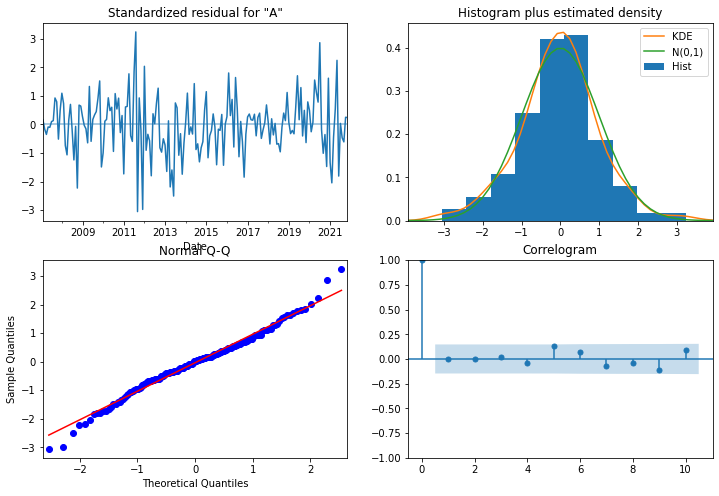

In [ ]:
model_results.plot_diagnostics(figsize=(12,8));

In [ ]:
model_results.resid.describe()

count    205.000000
mean      -0.073985
std        7.230028
min      -27.380004
25%       -3.858640
50%        0.158097
75%        3.300000
max       45.119999
dtype: float64

#### Previsioni con SARIMAX

In [ ]:
n = len(df_settle.index)
prediction = model_results.get_prediction(start=n-12*5, end = n+5)
prediction_ci = prediction.conf_int()

In [ ]:
print(prediction_ci.head())

            lower Adj Close  upper Adj Close
2016-12-31        99.220484       124.402257
2017-01-31       101.314271       126.437442
2017-02-28       104.332693       129.454530
2017-03-31       105.100043       130.221849
2017-04-30       107.259076       132.380882


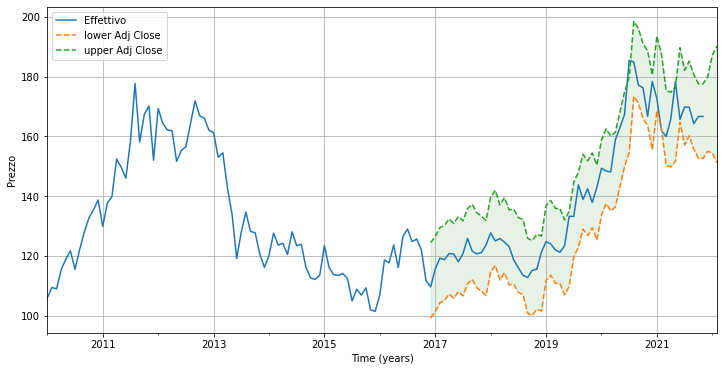

In [ ]:
plt.figure(figsize=(12,6))
ax = df_settle['2010':].plot(label = 'Effettivo')
prediction_ci.plot(ax=ax, style = ['--', '--'],
                  label = 'predicted/forecasted')
ci_index = prediction_ci.index
lower_ci = prediction_ci.iloc[:,0]
upper_ci = prediction_ci.iloc[:,1]

ax.fill_between(ci_index, lower_ci, upper_ci, color = 'g', alpha = 0.1)
ax.set_xlabel('Time (years)')
ax.set_ylabel('Prezzo')
plt.grid()
plt.legend()
plt.show()